In [2]:
import os
import sys
sys.path.append( os.path.abspath("../../workspace/python-work/python 3/cs230_deeplearning_implement/ec_code/")  )
from class4.week3.Car_detection_for_Autonomous_Driving.yolo_utils import *
from class4.week3.Car_detection_for_Autonomous_Driving.yad2k.models.keras_yolo import    yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body


import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model

%matplotlib inline

# YOLO（”you only look once”）只需要进行一次前向传播，
# 在使用非最大值抑制后，它与边界框一起输出识别对象。
# 
#输入的批量图片的维度为(m,608,608,3)
# 输出是一个识别分类与边界框的列表。每个边界框由6个数字组成：（px,bx,by,bh,bw,cpx,bx,by,bh,bw,c）。
# 如果你将cc放到80维的向量中，那么每个边界框就由85个数字组成。
#使用5个锚框（anchor boxes），算法大致流程是这样的：图像输入(m,608,608,3) ⇒⇒ DEEP CNN ⇒⇒ 编码(m,19,19,5,85)。    5 anchor box  85=80+5
# 为了方便，最后的两个维度的数据进行展开，所以最后一步的编码由(m,19,19,5,85)变为了(m,19,19,425)。
# 对YOLO的总结：
# 
# 输入图像为(608,608,3),输入的图像先要通过一个CNN模型，返回一个(19,19,5,85)的数据。
# 在对最后两维降维之后，输出的维度变为了(19,19,425): 每个19x19的单元格拥有425个数字。
# 425 = 5 x 85，即每个单元格拥有5个锚框，每个锚框由5个基本信息+80个分类预测构成,85 = 5 + 85，
# 其中5个基本信息是（pc,px,py,ph,pwpc,px,py,ph,pw）,剩下80就是80个分类的预测。
# 然后我们会根据以下规则选择锚框：
#           预测分数阈值：丢弃分数低于阈值的分类的锚框。   
#                       现在对个每个anchor（19,19,5）求出80个分类中概率p最大的class C，抛弃其他的class。然后看p是否满足score_threshold
#           非最大值抑制：（ non-maximum suppression (NMS)）     计算交并比（iou=intersection over union)，并避免选择重叠框。    
#                       iou_threshold==0.5   即使是我们通过阈值来过滤了一些得分较低的分类，但是我们依旧会有很多的锚框被留了下来
# 最后给出YOLO的最终输出。



In [3]:
# GRADED FUNCTION: iou

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    #计算相交的区域的面积
    xi1 = np.maximum(box1[0], box2[0])
    yi1 = np.maximum(box1[1], box2[1])
    xi2 = np.minimum(box1[2], box2[2])
    yi2 = np.minimum(box1[3], box2[3])
    inter_area = (xi1-xi2)*(yi1-yi2)

    #计算并集，公式为：Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    union_area = box1_area + box2_area - inter_area
    #计算交并比
    iou = inter_area / union_area
    return iou


box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


In [4]:
def yolo_filter_boxes(box_confidence , boxes, box_class_probs, threshold = 0.6):
    """
    预测分数阈值
    通过阈值来过滤对象和分类的置信度。
    参数：
        box_confidence  - tensor类型，维度为（19,19,5,1）,包含19x19单元格中每个单元格预测的5个锚框中的所有的锚框的pc （一些对象的置信概率）。
        boxes - tensor类型，维度为(19,19,5,4)，包含了所有的锚框的（px,py,ph,pw ）。
        box_class_probs - tensor类型，维度为(19,19,5,80)，包含了所有单元格中所有锚框的所有对象( c1,c2,c3，···，c80 )检测的概率。
        threshold - 实数，阈值，如果分类预测的概率高于它，那么这个分类预测的概率就会被保留。
    返回：
        scores - tensor 类型，维度为(None,)，包含了保留了的锚框的分类概率。
        boxes - tensor 类型，维度为(None,4)，包含了保留了的锚框的(b_x, b_y, b_h, b_w)
        classess - tensor 类型，维度为(None,)，包含了保留了的锚框的索引

    注意："None"是因为你不知道所选框的确切数量，因为它取决于阈值。
          比如：如果有10个锚框，scores的实际输出大小将是（10,）
    """

    #第一步：计算锚框的得分
    box_scores  = box_confidence * box_class_probs

    #第二步：找到最大值的锚框的索引以及对应的最大值的锚框的分数
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)

    #第三步：根据阈值创建掩码
    filtering_mask = (box_class_scores >= threshold)

    #对scores, boxes 以及 classes使用掩码
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)

    return scores , boxes , classes



# GRADED FUNCTION: yolo_non_max_suppression
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    为锚框实现非最大值抑制（ Non-max suppression (NMS)）
    参数：
        scores - tensor类型，维度为(None,)，yolo_filter_boxes()的输出
        boxes - tensor类型，维度为(None,4)，yolo_filter_boxes()的输出，已缩放到图像大小（见下文）
        classes - tensor类型，维度为(None,)，yolo_filter_boxes()的输出
        max_boxes - 整数，预测的锚框数量的最大值
        iou_threshold - 实数，交并比阈值。
    返回：
        scores - tensor类型，维度为(,None)，每个锚框的预测的可能值
        boxes - tensor类型，维度为(4,None)，预测的锚框的坐标
        classes - tensor类型，维度为(,None)，每个锚框的预测的分类
    注意："None"是明显小于max_boxes的，这个函数也会改变scores、boxes、classes的维度，这会为下一步操作提供方便。

    """
    max_boxes_tensor = K.variable(max_boxes,dtype="int32") #用于tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) #初始化变量max_boxes_tensor

    #使用使用tf.image.non_max_suppression()来获取与我们保留的框相对应的索引列表
    nms_indices = tf.image.non_max_suppression(boxes, scores,max_boxes,iou_threshold)

    #使用K.gather()来选择保留的锚框
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes







def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    将YOLO编码的输出（很多锚框）转换为预测框以及它们的分数，框坐标和类。
    参数：
        yolo_outputs - 编码模型的输出（对于维度为（608,608,3）的图片），包含4个tensors类型的变量：
                        box_confidence ： tensor类型，维度为(None, 19, 19, 5, 1)
                        box_xy         ： tensor类型，维度为(None, 19, 19, 5, 2)
                        box_wh         ： tensor类型，维度为(None, 19, 19, 5, 2)
                        box_class_probs： tensor类型，维度为(None, 19, 19, 5, 80)
        image_shape - tensor类型，维度为（2,），包含了输入的图像的维度，这里是(608.,608.)
        max_boxes - 整数，预测的锚框数量的最大值
        score_threshold - 实数，可能性阈值。
        iou_threshold - 实数，交并比阈值。
    返回：
        scores - tensor类型，维度为(,None)，每个锚框的预测的可能值
        boxes - tensor类型，维度为(4,None)，预测的锚框的坐标
        classes - tensor类型，维度为(,None)，每个锚框的预测的分类
    """
    #获取YOLO模型的输出
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    #中心点转换为边角
    boxes = yolo_boxes_to_corners(box_xy,box_wh)
    #可信度分值过滤
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    #缩放锚框，以适应原始图像
    boxes = scale_boxes(boxes, image_shape)
    # 使用非最大值抑制
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    return scores, boxes, classes






In [5]:
sess = K.get_session()
#定义分类、锚框与图像维度
#分类80个类别，使用5个锚框。两个文件“coco_classes.txt”和“yolo_anchors.txt”中关于80个类和5个锚框的信息。 
# 将这些数据加载到模型中。
class_names = read_classes(r"C:\workspace\python-work\python 3\cs230_deeplearning_implement\ec_code\class4\week3\Car_detection_for_Autonomous_Driving\model_data\coco_classes.txt")
anchors = read_anchors(r"C:\workspace\python-work\python 3\cs230_deeplearning_implement\ec_code\class4\week3\Car_detection_for_Autonomous_Driving\model_data\yolo_anchors.txt")
image_shape = (720., 1280.)  
#加载已经训练好了的模型,将加载存储在“yolov2.h5”中的现有预训练Keras YOLO模型。
yolo_model = load_model(r"C:\workspace\python-work\python 3\cs230_deeplearning_implement\ec_code\class4\week3\Car_detection_for_Autonomous_Driving\model_data\yolo.h5")


yolo_model.summary()


Instructions for updating:
Colocations handled automatically by placer.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
#将模型的输出转换为边界框  yolo_model的输出是一个（m，19,19,5,85）的tensor变量，它需要进行处理和转换。
#现在把yolo_outputs添加进了计算图中，
# 这4个tensor变量已准备好用作yolo_eval函数的输入。
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))


#过滤锚框,yolo_outputs已经正确的格式为我们提供了yolo_model的所有预测框，
# 现在已准备好执行过滤并仅选择最佳的锚框.调用之前实现的yolo_eval()
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)




In [7]:
#predict()函数，使用它来对图像进行预测
def predict(sess, image_file, is_show_info=True, is_plot=True):
    """
    运行存储在sess的计算图以预测image_file的边界框，打印出预测的图与信息。
    参数：
        sess - 包含了YOLO计算图的TensorFlow/Keras的会话。
        image_file - 存储在images文件夹下的图片名称
    返回：
        out_scores - tensor类型，维度为(None,)，锚框的预测的可能值。
        out_boxes - tensor类型，维度为(None,4)，包含了锚框位置信息。
        out_classes - tensor类型，维度为(None,)，锚框的预测的分类索引。 
    """

    #图像预处理
    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))
    #运行会话并在feed_dict中选择正确的占位符.
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict = {yolo_model.input:image_data, K.learning_phase(): 0})
    #打印预测信息
    if is_show_info:
        print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    #指定要绘制的边界框的颜色
    colors =generate_colors(class_names)
    #在图中绘制边界框
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    #保存已经绘制了边界框的图
    image.save(os.path.join("out", image_file), quality=100)
    #打印出已经绘制了边界框的图
    if is_plot:
        output_image = scipy.misc.imread(os.path.join("out", image_file))
        plt.imshow(output_image)
        
    return out_scores, out_boxes, out_classes


Found 2 boxes for C:\workspace\python-work\python 3\cs230_deeplearning_implement\ec_code\class4\week3\Car_detection_for_Autonomous_Driving\images\test.jpg
car 0.76 (361, 295) (747, 651)
car 0.78 (942, 327) (1280, 694)


C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


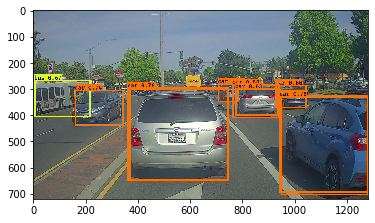

In [9]:
out_scores, out_boxes, out_classes =predict(sess, r"C:\workspace\python-work\python 3\cs230_deeplearning_implement\ec_code\class4\week3\Car_detection_for_Autonomous_Driving\images\test.jpg")